## Compute the azimuth and elevation phase maps

1. Compute the fft of each stimulation
2. To correct for phase delays subtract the phase of stimuli moving in opposite directions
3. Plot stimuli phase as time.

In [3]:
# from wfield import *
import pandas as pd
from tifffile import imwrite
import os
from os.path import join as pjoin
import numpy as np
from numpy.fft import fft
from matplotlib import pyplot as plt
import cv2

%matplotlib inline

In [ ]:
def reconstruct(u,svt,dims = None):
    if dims is None:
        dims = u.shape[:2]
    return u.dot(svt).reshape((*dims,-1)).transpose(-1,0,1).squeeze()


In [10]:
### 路径和刺激重复次数。（本代码对应的是每个方向连续重复10次再下一个方向）
path_wfield = r'Y:\WF_VC_liuzhaoxi\24.03.19_C92\retinotopy\process\20240319-203353-wfield'
nrepeats = 10
post_trial = 3   # 刺激消失后多取几秒

path_out = pjoin(path_wfield, '..', os.path.basename(path_wfield)[:16]+'retinotopy')
os.makedirs(path_out, exist_ok=True)


In [12]:
### load data
trials = pd.read_csv(pjoin(path_wfield, "trials.csv"), header=None, dtype=int).values
nframes_el = min(trials[:20, 3]) + post_trial*10
nframes_az = min(trials[20:40, 3]) + post_trial*10
# nframes_el = 130
# nframes_az = 163
U = np.load(pjoin(path_wfield, 'U.npy'))
SVTcorr = np.load(pjoin(path_wfield, 'SVTcorr.npy'))
# SVTcorr = np.load(pjoin(path_wfield, 'SVT.npy'))
nSVD = SVTcorr.shape[0]


### extract trial-data for 4 direction stimuli respectively.
def _sort_frames(nframes, *ntrials):
    avg = np.empty((nSVD, 0, nframes))
    raw = np.empty((nSVD, 0))
    for i in ntrials:
        avg = np.concatenate((avg, SVTcorr[:, trials[i, 1]:trials[i, 1] + nframes].reshape(nSVD, 1, nframes)), axis=1)
        raw = np.concatenate((raw, SVTcorr[:, trials[i, 1]:trials[i, 1] + nframes]), axis=1)
    avg = np.mean(avg, axis=1)
    return avg, raw

avg_up, raw_up = _sort_frames(nframes_el, *range(nrepeats * 0, nrepeats * 1))
avg_down, raw_down = _sort_frames(nframes_el, *range(nrepeats * 1, nrepeats * 2))
avg_left, raw_left = _sort_frames(nframes_az, *range(nrepeats * 2, nrepeats * 3))
avg_right, raw_right = _sort_frames(nframes_az, *range(nrepeats * 3, nrepeats * 4))


In [61]:
### computes fft in SVD space

# from scipy.ndimage import gaussian_filter,median_filter
# mov = runpar(median_filter, U.transpose((2, 0, 1)), size=5)
# U1 = np.stack(mov).transpose((1, 2, 0)).astype(np.float32)
up = reconstruct(U, fft(raw_up.T, axis=0)[nrepeats])
down = reconstruct(U, fft(raw_down.T, axis=0)[nrepeats])
left = reconstruct(U, fft(raw_left.T, axis=0)[nrepeats])
right = reconstruct(U, fft(raw_right.T, axis=0)[nrepeats])
phase_el = -1. * (np.angle(up) - np.angle(down)) % (2 * np.pi)
mag_el = (np.abs(up + down) * 2.)
phase_az = -1. * (np.angle(left) - np.angle(right)) % (2 * np.pi)
mag_az = (np.abs(left + right) * 2.)


In [77]:
fft_path = r'D:\Zhaoxi\mouse_vision\fft'

In [ ]:
svt_rep_up = raw_up.reshape(nSVD, nrepeats, nframes_el)
svt_rep_down = raw_down.reshape(nSVD, nrepeats, nframes_el)
svt_rep_left = raw_left.reshape(nSVD, nrepeats, nframes_az)
svt_rep_right = raw_right.reshape(nSVD, nrepeats, nframes_az)

rep_up = reconstruct(U, raw_up).reshape(nrepeats, nframes_el, *U.shape[:2])
rep_down = reconstruct(U, raw_down).reshape(nrepeats, nframes_el, *U.shape[:2])
rep_left = reconstruct(U, raw_left).reshape(nrepeats, nframes_az, *U.shape[:2])
rep_right = reconstruct(U, raw_right).reshape(nrepeats, nframes_az, *U.shape[:2])


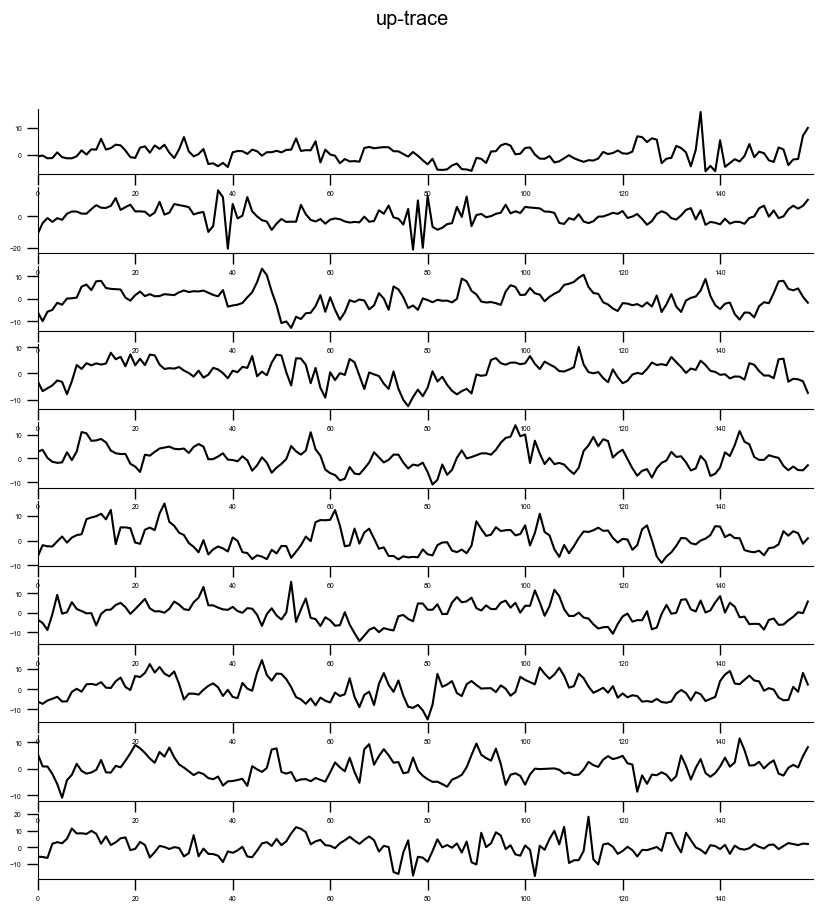

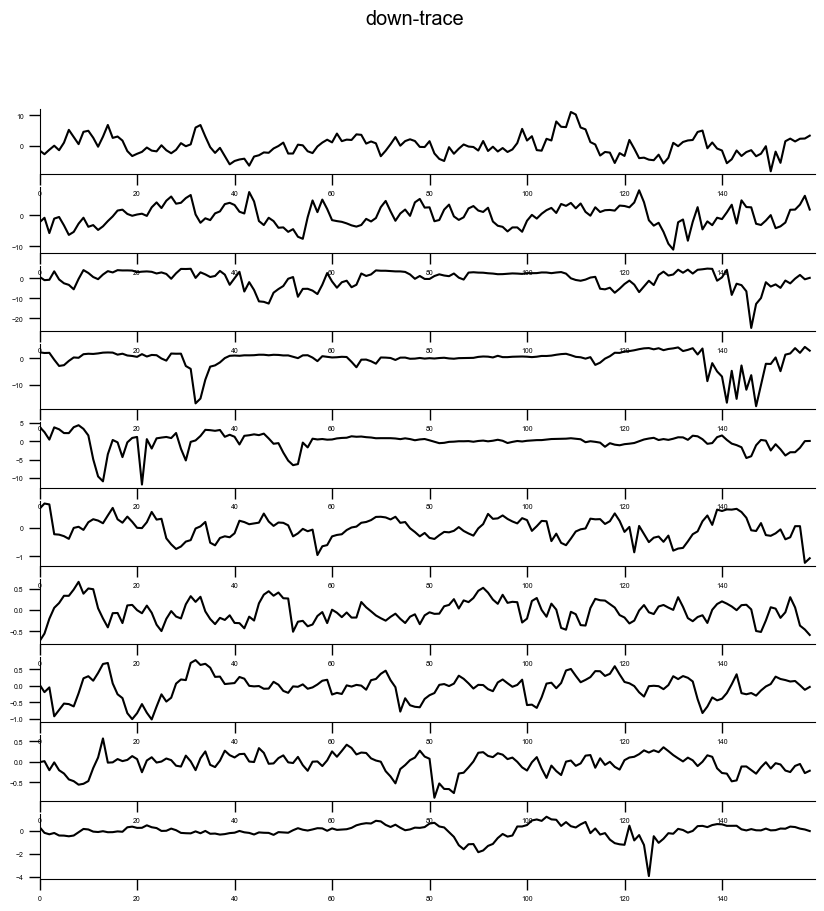

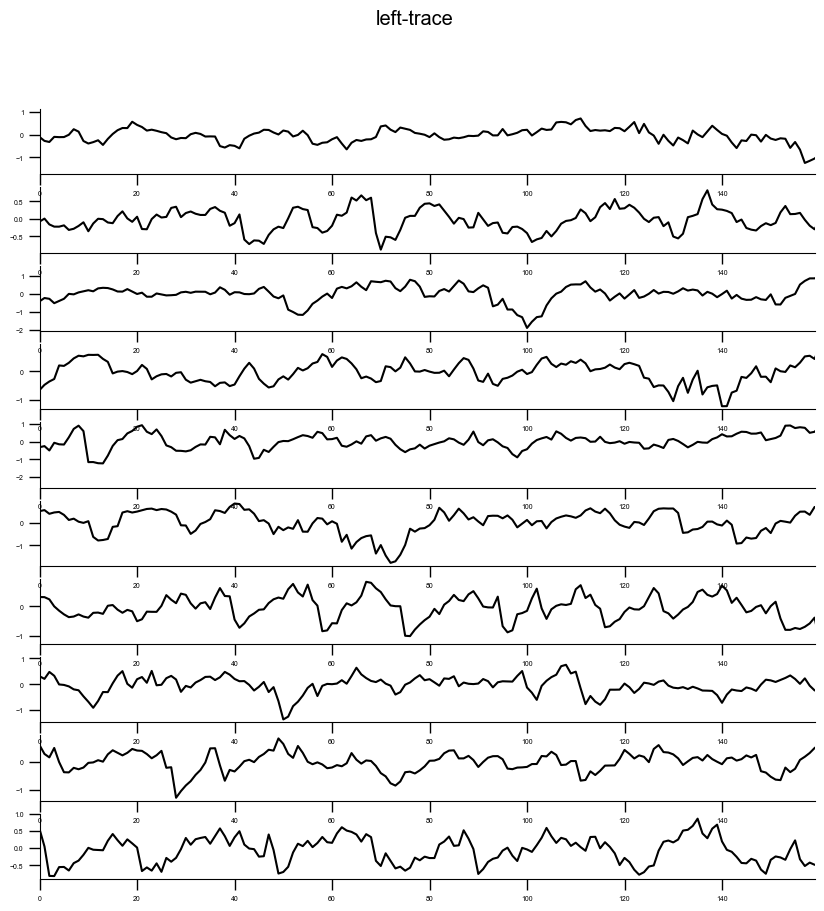

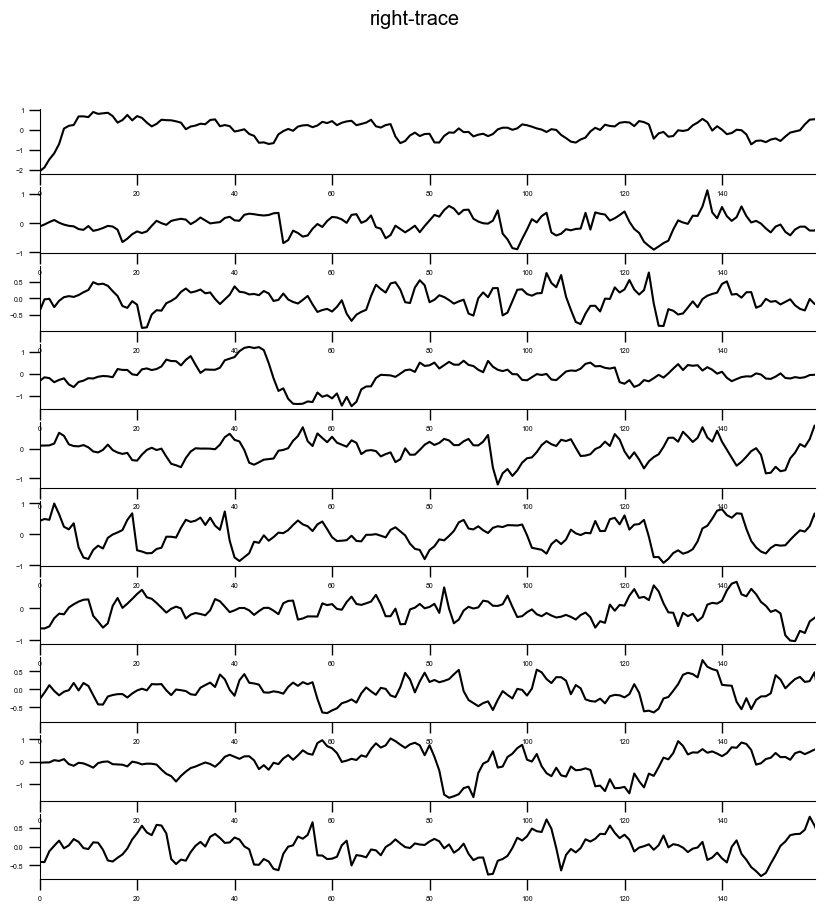

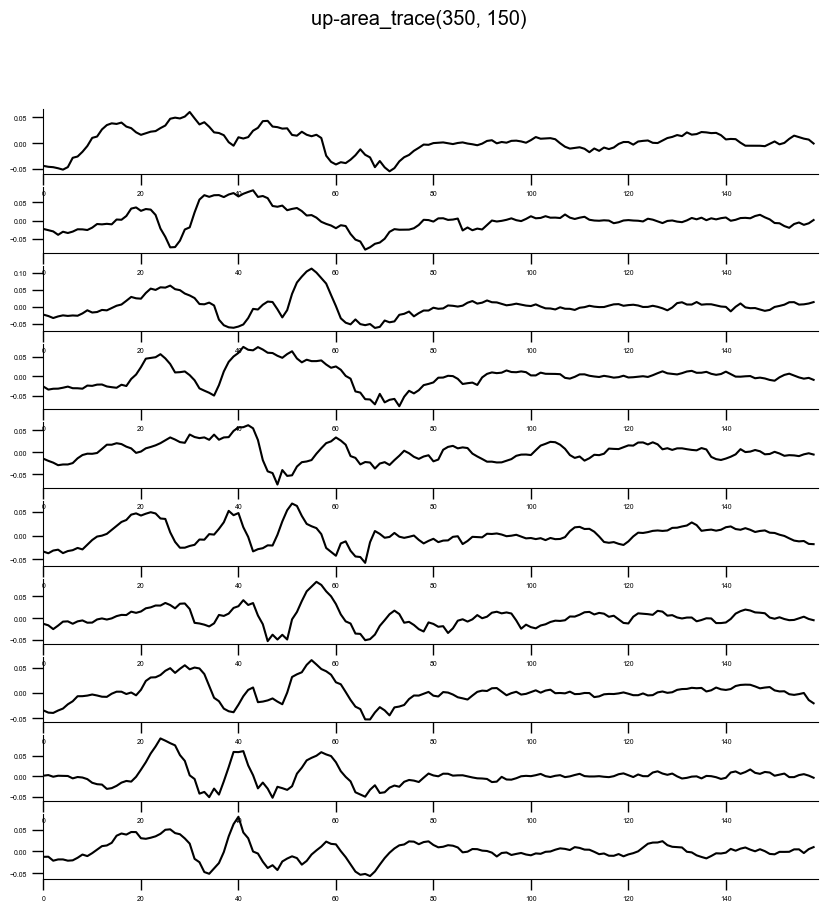

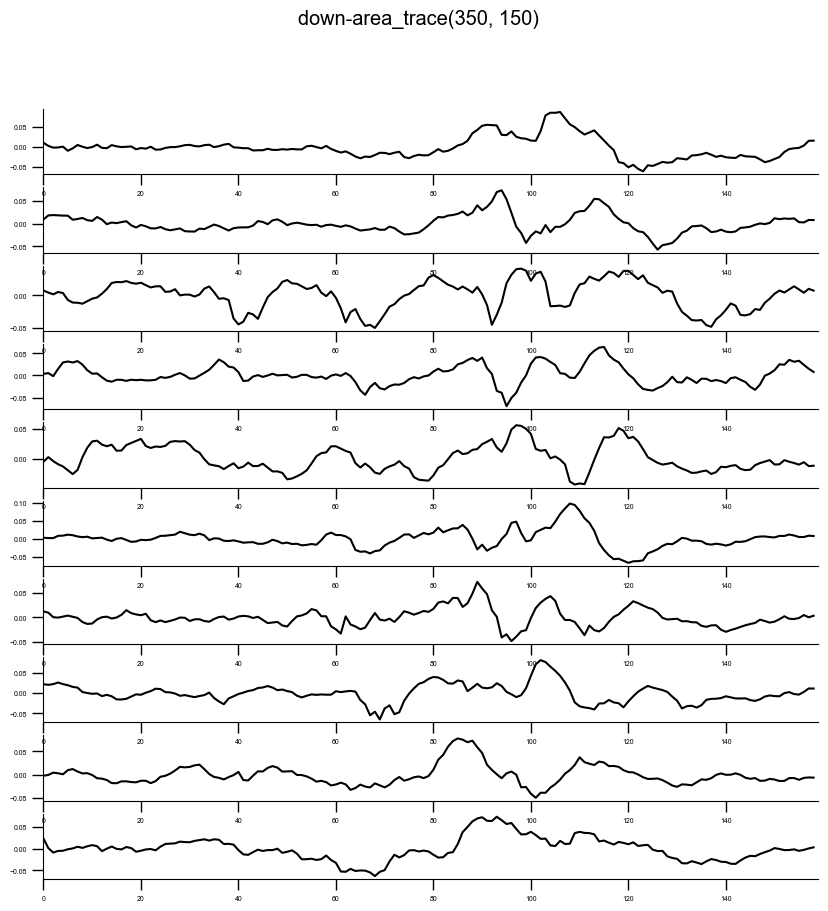

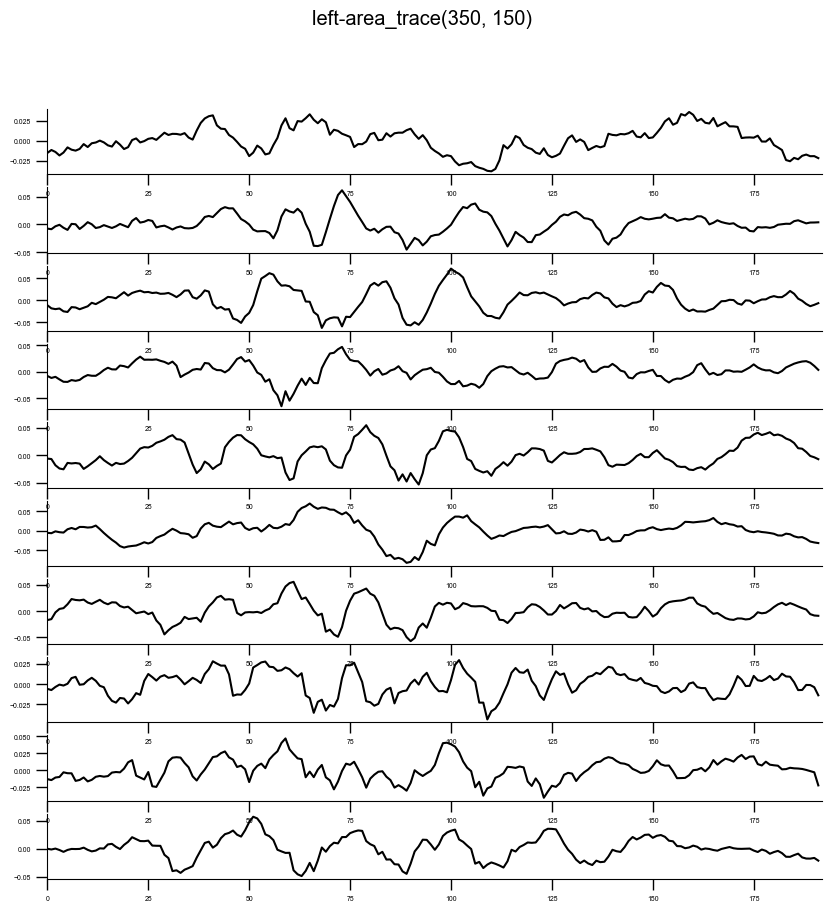

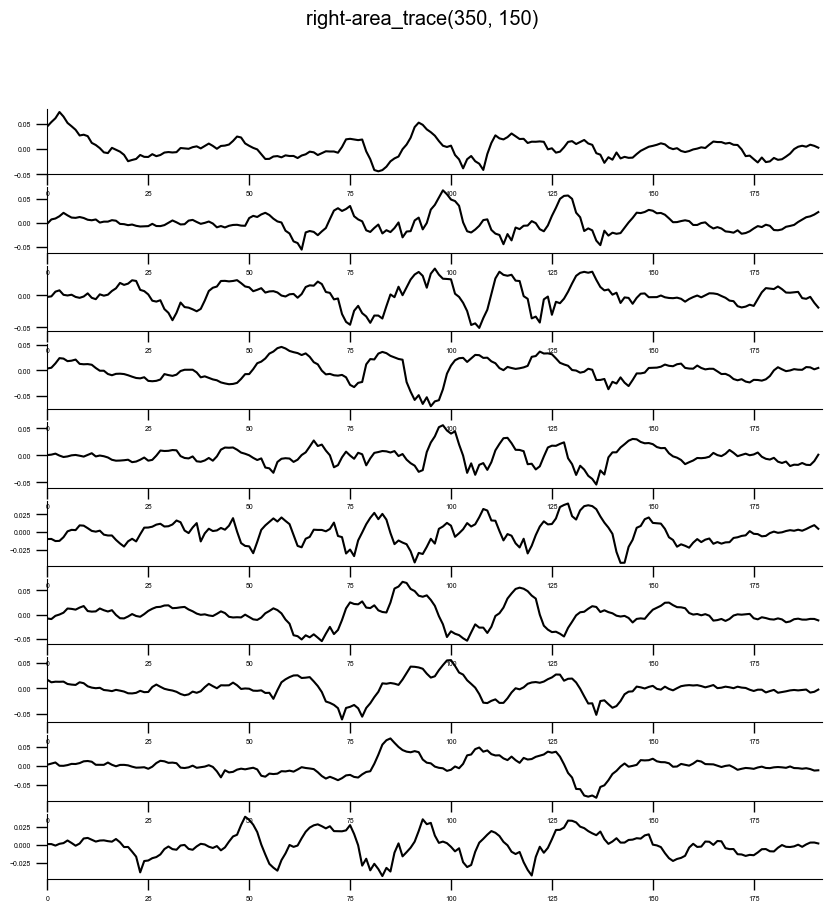

In [127]:
def plot_trace(rep, nrepeats, nframes, title, outfile):
    fig, axes = plt.subplots(nrepeats, 1, figsize=(10, 10))
    for i_rep in range(nrepeats):
        # axes[i_rep].plot(np.mean(rep_up[i_rep, :, 350:400, 100:150],axis=(1,2)))
        axes[i_rep].plot(rep[i_rep, :])
        axes[i_rep].set_xlim(0, nframes)
        axes[i_rep].tick_params(labelsize=5)
    plt.suptitle(title)
    plt.grid(False)
    plt.savefig(outfile, bbox_inches='tight', transparent=False, facecolor='white')
    plt.show()

plot_trace((svt_rep_up[0]), nrepeats, nframes_el, 'up-trace', pjoin(fft_path, 'up-trace.png'))
plot_trace((svt_rep_down[0]), nrepeats, nframes_el, 'down-trace', pjoin(fft_path, 'down-trace.png'))
plot_trace((svt_rep_left[0]), nrepeats, nframes_el, 'left-trace', pjoin(fft_path, 'left-trace.png'))
plot_trace((svt_rep_right[0]), nrepeats, nframes_el, 'right-trace', pjoin(fft_path, 'right-trace.png'))


plot_trace(rep_up[:, :, 350, 150], nrepeats, nframes_el, 'up-area_trace(350, 150)', pjoin(fft_path, 'up-area_trace.png'))
plot_trace(rep_down[:, :, 350, 150], nrepeats, nframes_el, 'down-area_trace(350, 150)', pjoin(fft_path, 'down-area_trace.png'))
plot_trace(rep_left[:, :, 350, 150], nrepeats, nframes_az, 'left-area_trace(350, 150)', pjoin(fft_path, 'left-area_trace.png'))
plot_trace(rep_right[:, :, 350, 150], nrepeats, nframes_az, 'right-area_trace(350, 150)', pjoin(fft_path, 'right-area_trace.png'))


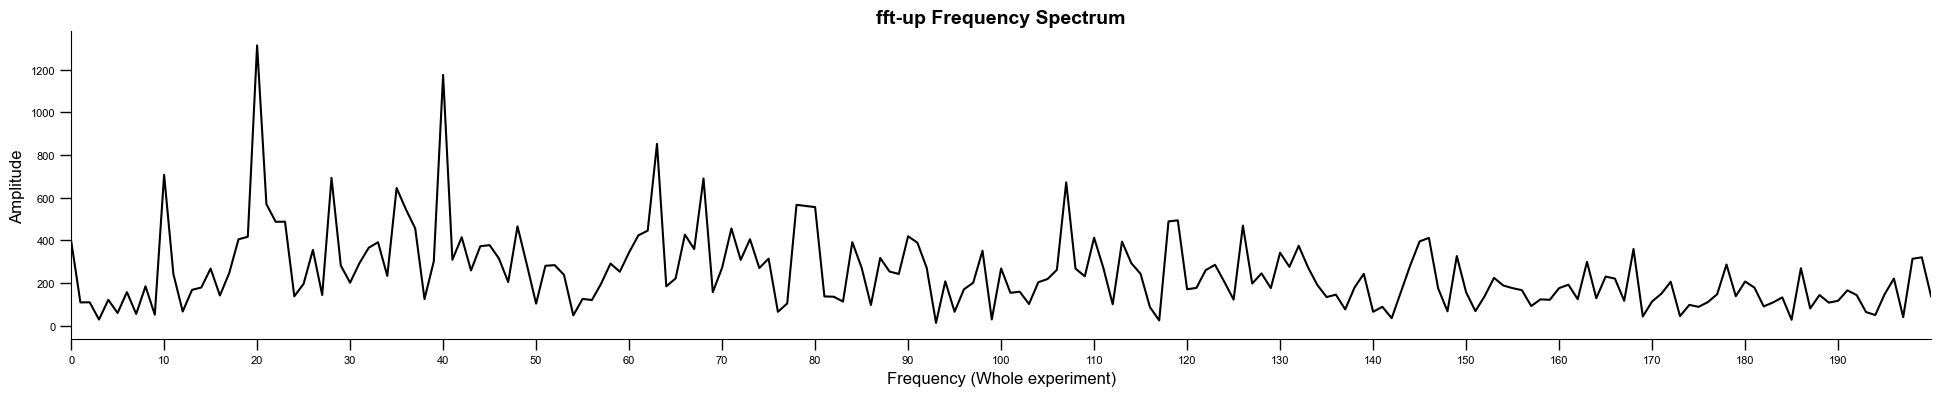

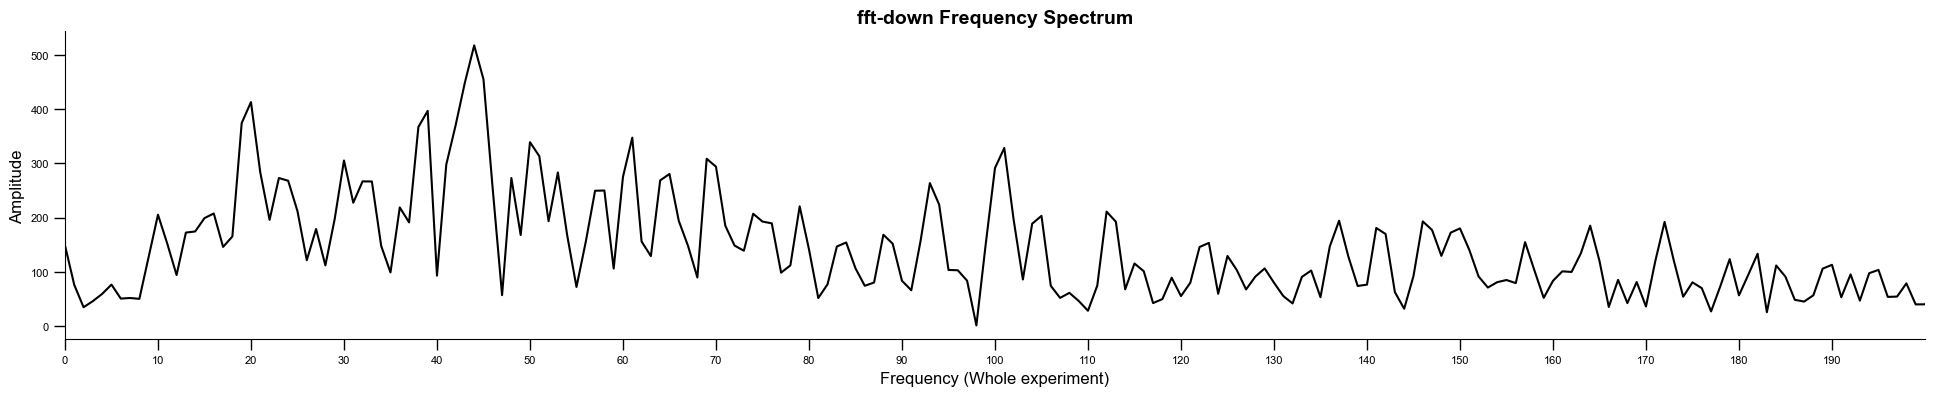

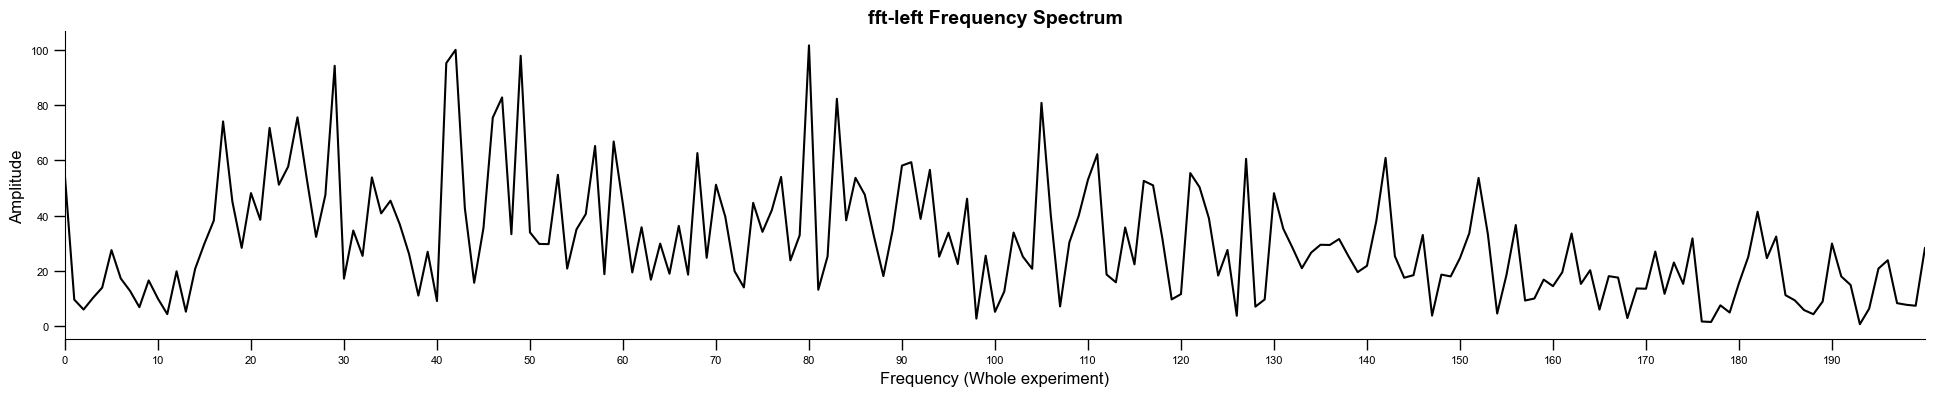

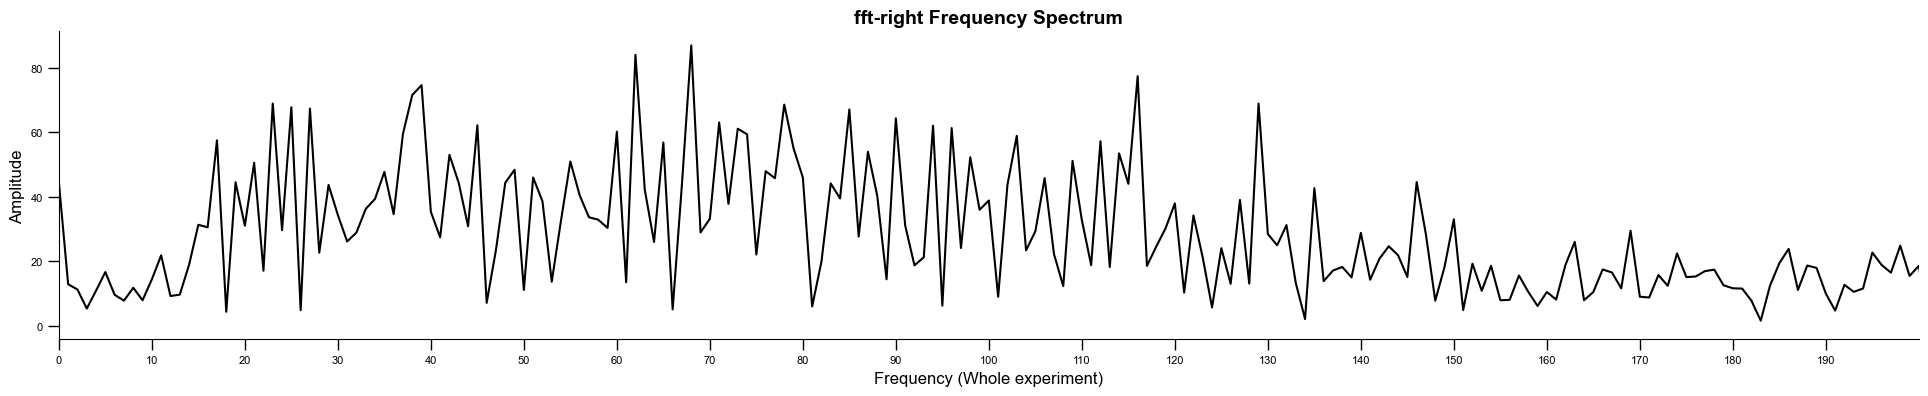

In [128]:
def plot_fft_spectrum(data, title, outfile):
    fft_result=fft(data)
    sampling_frequency = 10  # Hz
    # 计算频率轴
    N = len(fft_result)  # fft_result 的长度
    freq = np.fft.fftfreq(N, d=1/sampling_frequency)
    # 绘制频谱图
    plt.figure(figsize=(24, 4))
    # plt.plot(freq[:N//2], np.abs(fft_result[:N//2]))  # 仅绘制正频率部分
    plt.plot(np.abs(fft_result[:N//2]))
    plt.title(title)
    plt.xlabel('Frequency (Whole experiment)')
    plt.ylabel('Amplitude')
    plt.xlim([0, 200])
    plt.xticks(range(0, 200, 10))
    plt.grid(False)
    plt.savefig(outfile, bbox_inches='tight', transparent=False, facecolor='white')

plot_fft_spectrum(raw_up[0, :], 'fft-up Frequency Spectrum', pjoin(fft_path, 'fft_up.png'))
plot_fft_spectrum(raw_down[0, :], 'fft-down Frequency Spectrum', pjoin(fft_path, 'fft_down.png'))
plot_fft_spectrum(raw_left[0, :], 'fft-left Frequency Spectrum', pjoin(fft_path, 'fft_left.png'))
plot_fft_spectrum(raw_right[0, :], 'fft-right Frequency Spectrum', pjoin(fft_path, 'fft_right.png'))


In [ ]:
def phasemap_to_visual_degrees(phasemap,startdeg,stopdeg):
    '''
    Normalizes the phasemap to visual angles
    Joao Couto 2019
    '''
    res = phasemap.copy() - np.nanmin(phasemap)
    res /= np.nanmax(res)
    res *= np.abs(np.diff([startdeg,stopdeg]))
    res += startdeg
    return res

In [84]:
phase_el_degree = phasemap_to_visual_degrees(phase_el,-23.2, 73.2)
phase_az_degree = phasemap_to_visual_degrees(phase_az,-18.2, 108.2)


In [106]:
frames_ave = np.load(pjoin(path_wfield, 'frames_average.npy'))[0]

In [107]:
# up1 = reconstruct(U, fft(avg_up.T, axis=0)[1])
# down1 = reconstruct(U, fft(avg_down.T, axis=0)[1])
# left1 = reconstruct(U, fft(avg_left.T, axis=0)[1])
# right1 = reconstruct(U, fft(avg_right.T, axis=0)[1])
up1 = fft(reconstruct(U, avg_up)*frames_ave, axis=0)[1]
down1 = fft(reconstruct(U, avg_down)*frames_ave, axis=0)[1]
left1 = fft(reconstruct(U, avg_left)*frames_ave, axis=0)[1]
right1 = fft(reconstruct(U, avg_right)*frames_ave, axis=0)[1]
phase_el1 = -1. * (np.angle(up1) - np.angle(down1)) % (2 * np.pi)
mag_el1 = (np.abs(up1 + down1) * 2.)
phase_az1 = -1. * (np.angle(left1) - np.angle(right1)) % (2 * np.pi)
mag_az1 = (np.abs(left1 + right1) * 2.)

phase_el_degree1 = phasemap_to_visual_degrees(phase_el1, -23.2, 73.2)
phase_az_degree1 = phasemap_to_visual_degrees(phase_az1, -18.2, 108.2)

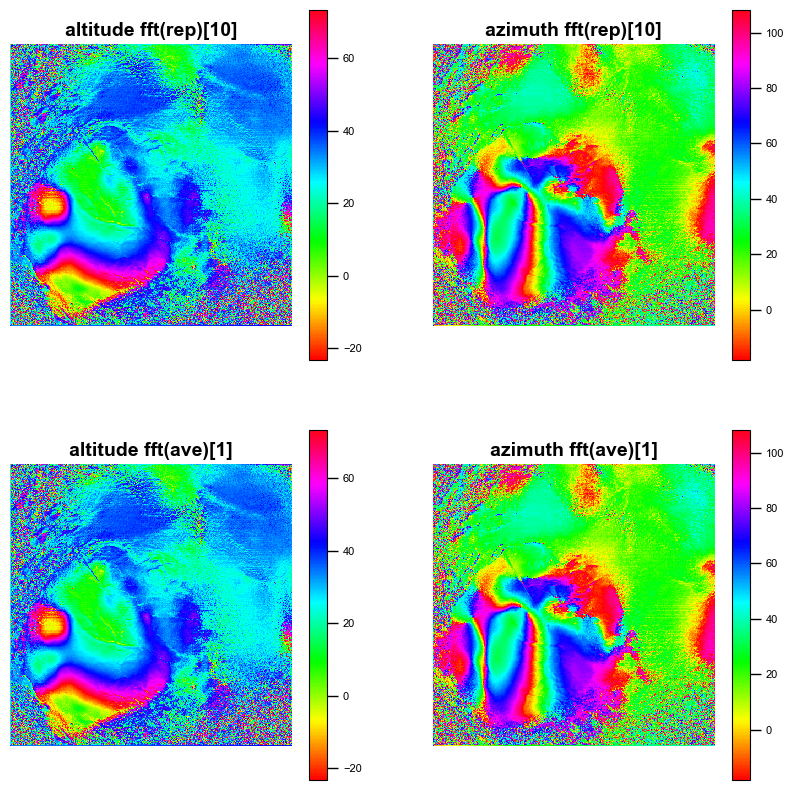

In [124]:
fig = plt.figure(figsize=(10, 10))

fig_phase_el_degree = fig.add_subplot(221)
currfig = plt.imshow(phase_el_degree, cmap='hsv', interpolation='nearest')
fig.colorbar(currfig)
fig_phase_el_degree.set_axis_off()
fig_phase_el_degree.set_title('altitude fft(rep)[10]')

fig_phase_az_degree = fig.add_subplot(222)
currfig = plt.imshow(phase_az_degree, cmap='hsv', interpolation='nearest')
fig.colorbar(currfig)
fig_phase_az_degree.set_axis_off()
fig_phase_az_degree.set_title('azimuth fft(rep)[10]')

fig_phase_el_degree1 = fig.add_subplot(223)
currfig = plt.imshow(phase_el_degree1, cmap='hsv', interpolation='nearest')
fig.colorbar(currfig)
fig_phase_el_degree1.set_axis_off()
fig_phase_el_degree1.set_title('altitude fft(ave)[1]')

fig_phase_az_degree1 = fig.add_subplot(224)
currfig = plt.imshow(phase_az_degree1, cmap='hsv', interpolation='nearest')
fig.colorbar(currfig)
fig_phase_az_degree1.set_axis_off()
fig_phase_az_degree1.set_title('azimuth fft(ave)[1]')

fig.set_facecolor('white')
plt.savefig(pjoin(fft_path,'phasemap'), bbox_inches='tight')
plt.show()


In [125]:
delta_phase_el = phase_el_degree1 - phase_el_degree
print("delta_phase_el.max:",delta_phase_el.max())

delta_phase_az = phase_az_degree1 - phase_az_degree
print("delta_phase_az.max:",delta_phase_az.max())

delta_phase_el.max: 5.8690829973784275e-12
delta_phase_az.max: 9.976020010071807e-12


In [ ]:
def fft_movie(movie, component = 1,output_raw = False):
    '''
    Computes the fft of a movie and returns the magnitude and phase 
    '''
    movief = fft(movie, axis = 0)
    if output_raw:
        return movief[component]
    phase  = -1. * np.angle(movief[component]) % (2*np.pi)
    mag = (np.abs(movief[component])*2.)/len(movie)
    return mag,phase

def im_fftphase_hsv(mov,component = 1,vperc=98,sperc=90,return_hsv=False):
    '''
    im_fftphase_hsv(mov,blur = 0,vperc=99,sperc=90)
    
    Creates a color image colorcoding the frame with fourier phase for each pixel 
    
        mov can be a 3d array or a list with the [magnitude, phase]
'''
    
    if not type(mov) is list:
        mag,H = fft_movie(mov,component = component)
    else:
        mag,H = mov
    H = H/(2*np.pi)
    V = mag.copy()
    V /= np.percentile(mag,vperc)
    S = mag**0.3
    S /= np.percentile(S,sperc)
    if return_hsv:
        return np.stack([H,S,V],axis=2).astype(np.float32)
    # Normalization for opencv ranges 0-255 for uint8
    hsvimg = np.clip(np.stack([H,S,V],axis=2).astype(np.float32),0,1)
    hsvimg *= 255
    return cv2.cvtColor(hsvimg.astype(np.uint8), cv2.COLOR_HSV2RGB_FULL)

def visual_sign_map(phasemap1, phasemap2):
    '''
    Computes the visual sign map from azimuth and elevation phase maps
    This is adapted from the Allen retinotopy code
    '''
    import math    
    import scipy.ndimage as ni
    
    gradmap1 = np.gradient(phasemap1)
    gradmap2 = np.gradient(phasemap2)
    graddir1 = np.zeros(np.shape(gradmap1[0]))
    graddir2 = np.zeros(np.shape(gradmap2[0]))
    for i in range(phasemap1.shape[0]):
        for j in range(phasemap2.shape[1]):
            graddir1[i, j] = math.atan2(gradmap1[1][i, j], gradmap1[0][i, j])
            graddir2[i, j] = math.atan2(gradmap2[1][i, j], gradmap2[0][i, j])
    vdiff = np.multiply(np.exp(1j * graddir1), np.exp(-1j * graddir2))
    areamap = np.sin(np.angle(vdiff))
    return areamap


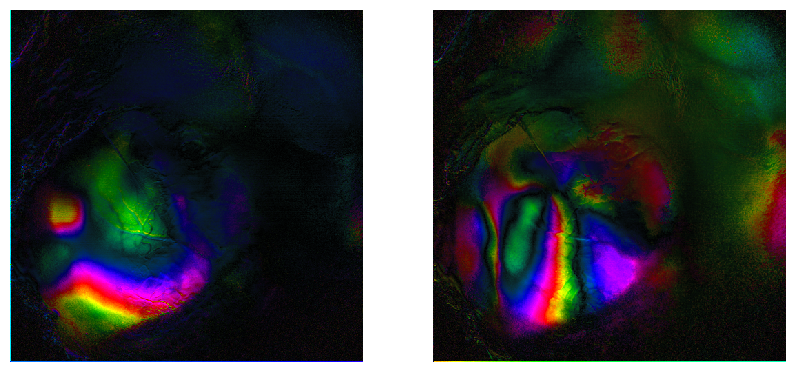

In [122]:
### plot phase maps

fig = plt.figure(figsize=[10, 5])
fig.add_subplot(1, 2, 1)
plt.imshow(im_fftphase_hsv([mag_el, phase_el], return_hsv=False))
plt.axis('off')
fig.add_subplot(1, 2, 2)
plt.imshow(im_fftphase_hsv([mag_az, phase_az], return_hsv=False))
plt.axis('off')
fig.set_facecolor('white')
plt.savefig(pjoin(path_out, 'el_az_unfiltered.png'))


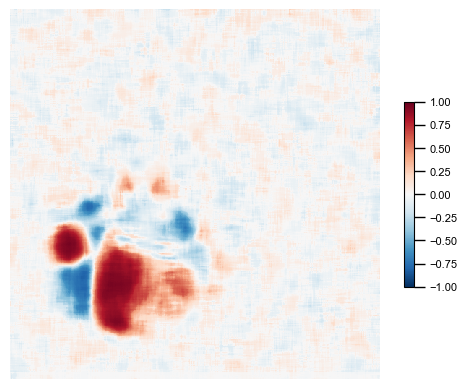

In [89]:
### plot sign maps

from scipy.ndimage import median_filter
fig = plt.figure()
plt.imshow(median_filter(visual_sign_map(phase_az, phase_el), 20),
           cmap='RdBu_r', clim=[-1, 1])
plt.colorbar(shrink=0.5)
plt.axis('off')
fig.set_facecolor('white')
plt.savefig(pjoin(path_out, 'signmap.png'))


In [41]:
### export phase and magnitude

np.save(pjoin(path_out, 'phase_el.npy'), phase_el)
np.save(pjoin(path_out, 'phase_az.npy'), phase_az)
np.save(pjoin(path_out, 'mag_el.npy'), mag_el)
np.save(pjoin(path_out, 'mag_az.npy'), mag_az)


C:\Users\jiali\AppData\Local\Temp\ipykernel_70060\388887700.py:15: RuntimeWarning: divide by zero encountered in divide
  plt.plot(fs/frequencies, psd_values)


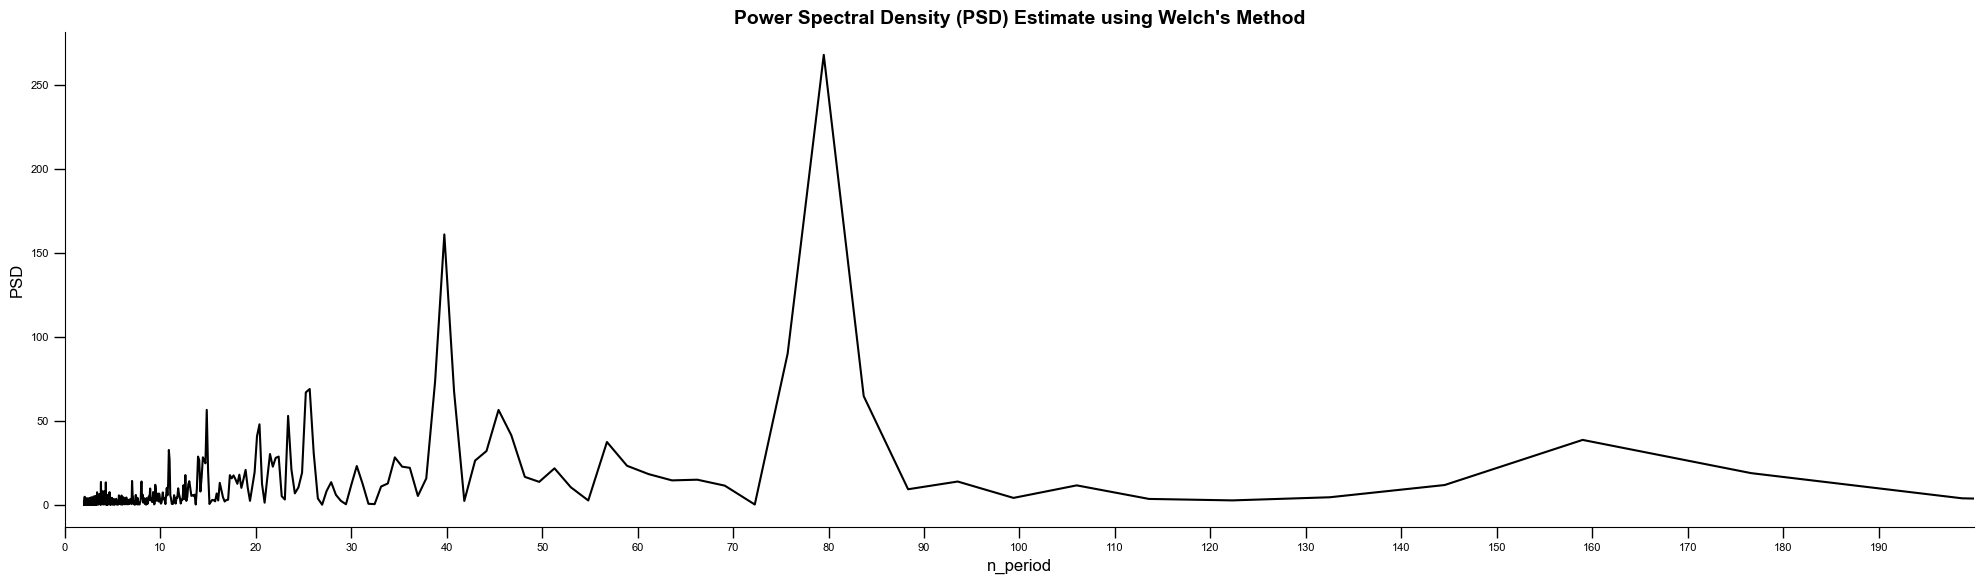

In [167]:
########################### welch方法

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# Generate a noisy signal for demonstration
fs = 10  # Sampling frequency in Hz
# Apply Welch's method to estimate the PSD
frequencies, psd_values = welch(raw_up[0, :], fs, nperseg=nframes_el*nrepeats)

# Plotting the estimated PSD
fig = plt.figure(figsize=(20, 6))
plt.plot(fs/frequencies, psd_values)
plt.title('Power Spectral Density (PSD) Estimate using Welch\'s Method')
# plt.xlabel('Frequency (Hz)')
plt.xlabel('n_period')
plt.ylabel('PSD')
plt.xlim([0, 200])
plt.xticks(range(0, 200, 10))
plt.tight_layout()
plt.show()